# MODEL VALIDATION

In [1]:
import xrft
import os
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.manual_seed(42)

from models.CNN import CNN
from models.Pix2Pix import Generator

from dataset import Agulhas3
from utils import plot_examples

%matplotlib inline

## Utils

In [2]:
def psnr(original, reconstructed, R=2.0):
    
    if isinstance(original, (np.ndarray, np.generic)):
    
        mse = (np.square(original - reconstructed)).mean(axis=(1, 2))
        psnr = 20 * np.log10(R / np.sqrt(mse))
    
    else:
        mse = F.mse_loss(original, reconstructed, reduction='none').mean(dim=(1, 2))
        psnr = 20 * torch.log10(R / torch.sqrt(mse))
    
    return psnr

def ECDF(**kwargs):
    fig, ax = plt.subplots()
    
    for kwarg, value in kwargs.items():
        x = np.sort(value)
        y = np.arange(1, len(value) + 1) / len(value)
        ax.plot(x, y, linestyle='--', alpha=1, label=kwarg)
    
    ax.legend()
    plt.show()

def load_training_reports(checkpoint_root, two_head=False):
    
    RESTORE_FROM = os.path.join('outputs', checkpoint_root, 'snapshots')
    
    if two_head:
        with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
            loss_arr = np.load(f)
            psnr_bm_arr = np.load(f)
            psnr_it_arr = np.load(f)
        
        return loss_arr, psnr_bm_arr, psnr_it_arr
    else:
        
        with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
            loss_arr = np.load(f)
            psnr_arr = np.load(f)
    
        return loss_arr, psnr_arr

def load_checkpoint(checkpoint_root, checkpoint_file, model, pth_name='model.pth.tar'):
    
    RESTORE_FROM = os.path.join('outputs', checkpoint_root, 'snapshots', checkpoint_file, pth_name)
    print(RESTORE_FROM)
    
    checkpoint = torch.load(RESTORE_FROM)
    
    try:
        model.load_state_dict(checkpoint["state_dict"])
    
    except KeyError:
        model.load_state_dict(checkpoint['model_state_dict'])

## Load Validation set

In [3]:
PERSISTENT_BUCKET = 'gs://leap-persistent/dhruvbalwada'
unfiltered_link = PERSISTENT_BUCKET + '/ssh_reconstruction_project/unfiltered_data.zarr'
filtered_link = PERSISTENT_BUCKET+'/ssh_reconstruction_project/filtered_data.zarr'

In [4]:
da_unfiltered = xr.open_zarr(unfiltered_link)['ssh_unfiltered'].compute()
da_filtered = xr.open_zarr(filtered_link)['ssh_filtered'].compute()
da_it = da_unfiltered - da_filtered

In [5]:
rng = np.random.default_rng(2019)
arr = np.arange(70)
rng.shuffle(arr)

inputs = da_unfiltered[arr[49:56], 56:-56, 56:-56].fillna(0).values 
targets_bm = da_filtered[arr[49:56], 56:-56, 56:-56].fillna(0).values
targets_it = da_it[arr[49:56], 56:-56, 56:-56].fillna(0).values

In [6]:
print(inputs.shape, targets_bm.shape, targets_it.shape)

(7, 2048, 2048) (7, 2048, 2048) (7, 2048, 2048)


## Load Models

In [7]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

CNN_VB = CNN(second_component=False, head_activation=nn.Tanh()).cuda(); load_checkpoint('00-CNN-T05', 'epoch-090', CNN_VB)
CNN_V1 = CNN(second_component=False, head_activation=nn.Tanh()).cuda(); load_checkpoint('00-CNN-T09', 'epoch-090', CNN_V1)
CNN_V2 = CNN(second_component=False, head_activation=nn.Tanh()).cuda(); load_checkpoint('00-CNN-T12', 'epoch-100', CNN_V2)

outputs/00-CNN-T05/snapshots/epoch-090/model.pth.tar
outputs/00-CNN-T09/snapshots/epoch-090/model.pth.tar
outputs/00-CNN-T12/snapshots/epoch-100/model.pth.tar


In [8]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

CGANB = Generator(in_channels=1, features=64).cuda(); load_checkpoint('11-PIX2PIX', 'epoch-200', CGANB, pth_name='generator.pth.tar')
CGANV1 = Generator(in_channels=1, features=64).cuda(); load_checkpoint('12-PIX2PIX', 'epoch-100', CGANV1, pth_name='generator.pth.tar')
CGANV2 = Generator(in_channels=1, features=64).cuda(); load_checkpoint('13-PIX2PIX', 'epoch-050', CGANV2, pth_name='generator.pth.tar')
CGANV3 = Generator(in_channels=1, features=64).cuda(); load_checkpoint('14-PIX2PIX', 'epoch-100', CGANV3, pth_name='generator.pth.tar')
CGANFN = Generator(in_channels=1, features=64).cuda(); load_checkpoint('16-PIX2PIX', 'epoch-500', CGANFN, pth_name='generator.pth.tar')

outputs/11-PIX2PIX/snapshots/epoch-200/generator.pth.tar
outputs/12-PIX2PIX/snapshots/epoch-100/generator.pth.tar
outputs/13-PIX2PIX/snapshots/epoch-050/generator.pth.tar
outputs/14-PIX2PIX/snapshots/epoch-100/generator.pth.tar
outputs/16-PIX2PIX/snapshots/epoch-500/generator.pth.tar


In [9]:
MinMax_transform_dict = {'inputs' : (-2.0309153, 1.098078), 'targets_it': (-0.121434465, 0.12447834), 'targets_bm': (-2.032202, 1.0936853)}
Standard_transform_dict = {'inputs' : (-0.4315792, 0.5710749), 'targets_it': (2.9930247e-06, 0.009364196), 'targets_bm': (-0.43158054, 0.57093924)}

def transformation(data, transform_parameters, transform_method='MinMax', inverse_transform=False):
    
    if transform_method == 'MinMax':
        
        if inverse_transform:
            data = (data + 1) / 2
            data = data * (transform_parameters[1] - transform_parameters[0]) + transform_parameters[0]
            return data
        
        data = (data - transform_parameters[0]) / (transform_parameters[1] - transform_parameters[0])
        return (2 * data) - 1
    
    if transform_method == 'Standard':
        
        if inverse_transform:
            data = data * transform_parameters[1] + transform_parameters[0]
            return data
        
        data = (data - transform_parameters[0]) / transform_parameters[1]
        return data

def reshape_arr(arr): # (2048, 2048)
    
    arr = arr.reshape(8, 256, 8, 256) # (8, 256, 8, 256)
    arr = arr.transpose(0, 2, 1, 3)   # (8, 8, 256, 256)
    arr = arr.reshape(-1, 1, 256, 256)   # (64, 1, 256, 256)
    
    return arr

def reshape_back_arr(arr): # (7, 64, 256, 256)
    
    arr = arr.reshape(7, 8, 8, 256, 256)
    arr = arr.transpose(0, 1, 3, 2, 4)   # (7, 8, 256, 8, 256)
    arr = arr.reshape(-1, 2048, 2048)   # (7, 2048, 2048)
    
    return arr

def metrics_report(original, recunstructed):
    
    instance_numbers = original.shape[0]
    
    r2 = r2_score(original.reshape(instance_numbers, -1), recunstructed.reshape(instance_numbers, -1))
    mse = mean_squared_error(recunstructed.reshape(instance_numbers, -1), recunstructed.reshape(instance_numbers, -1), squared=False)
    pbias = 100 * np.sum(recunstructed - original) / np.sum(original)
    
    print(f'R2: {r2:.4f}, PBias: {pbias:.4f}, RMSE: {mse:.4f}')

In [10]:
def inference(model, dataset, CNN=True):
    
    if CNN:
        dataset_tensor = torch.tensor(dataset, dtype=torch.float32)
        dataset_tensor = torch.unsqueeze(dataset_tensor, 1)
        gens = np.empty((0, 2048, 2048))

        model = model.cuda()
        model.eval()
        with torch.no_grad():
            
            loop = tqdm(dataset_tensor, leave=True)
            for batch in loop:

                # GPU deployment
                ssh = batch.cuda()

                # Compute prediction
                gen = model(ssh).detach().cpu().numpy()           

                gens = np.concatenate((gens, gen) , axis=0)

        return gens

    
    dataset_tensor = torch.tensor(dataset, dtype=torch.float32)
    dataset_tensor = torch.unsqueeze(dataset_tensor, 1)
    gens = np.empty((0, 64, 256, 256))
    
    model = model.cuda()
    model.eval()
    with torch.no_grad():
        
        loop = tqdm(dataset, leave=True)
        for time_slice in loop: # (2048, 2048)
            tgens = np.empty((1, 0, 256, 256))
            patches = reshape_arr(time_slice)

            for patch in patches: # (1, 256, 256)
                
                # GPU deployment
                patch_tensor = torch.tensor(np.array(patch), dtype=torch.float32)
                patch_tensor = torch.unsqueeze(patch_tensor, 0).cuda() # (1, 1, 256, 256)

                # Compute prediction
                gen = model(patch_tensor).detach().cpu().numpy()  # (1, 1, 256, 256)           
                tgens = np.concatenate((tgens, gen) , axis=1) # (1, 64, 256, 256)
            
            gens = np.concatenate((gens, tgens) , axis=0)
    
    return gens

In [12]:
ssh = transformation(inputs, MinMax_transform_dict['inputs'], transform_method='MinMax', inverse_transform=False)
bms = transformation(targets_bm, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=False)
its = transformation(targets_it, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=False)

In [12]:
BMVB = inference(CNN_VB, ssh)
BMV1 = inference(CNN_V1, ssh)
BMV2 = inference(CNN_V2, ssh)

100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


In [13]:
TBMVB = transformation(BMVB, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)
TBMV1 = transformation(BMV1, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)
TBMV2 = transformation(BMV2, MinMax_transform_dict['targets_bm'], transform_method='MinMax', inverse_transform=True)

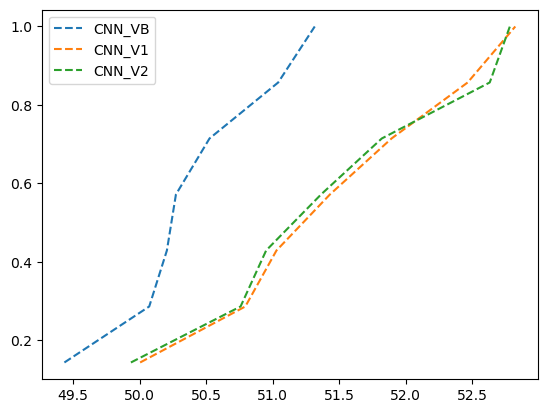

In [42]:
RSSH = 1.098078 + 2.0309153
RIT = 0.12447834 + 0.121434465
RBM = 1.0936853 + 2.032202
ECDF(CNN_VB=psnr(targets_bm, TBMVB, R=RBM), CNN_V1=psnr(targets_bm, TBMV1, R=RBM), CNN_V2=psnr(targets_bm, TBMV2, R=RBM))

In [14]:
print('TBMVB: '), metrics_report(targets_bm, TBMVB)
print('TBMV1: '), metrics_report(targets_bm, TBMV1)
print('TBMV2: '), metrics_report(targets_bm, TBMV2)

TBMVB: 
R2: 0.5821, PBias: -0.1754, RMSE: 0.0000
TBMV1: 
R2: 0.6405, PBias: -0.1396, RMSE: 0.0000
TBMV2: 
R2: 0.6105, PBias: -0.1732, RMSE: 0.0000


(None, None)

In [15]:
da_ssh = xr.DataArray(inputs, dims=['z', 'x', 'y'])
da_bm = xr.DataArray(targets_bm, dims=['z', 'x', 'y'])

da_bmvb = xr.DataArray(TBMVB, dims=['z', 'x', 'y'])
da_bmv1 = xr.DataArray(TBMV1, dims=['z', 'x', 'y'])
da_bmv2 = xr.DataArray(TBMV2, dims=['z', 'x', 'y'])

ps_ssh = xrft.power_spectrum(da_ssh, 'x', window='hamming')
ps_bm = xrft.power_spectrum(da_bm, 'x', window='hamming')

ps_bmvb = xrft.power_spectrum(da_bmvb, 'x', window='hamming')
ps_bmv1 = xrft.power_spectrum(da_bmv1, 'x', window='hamming')
ps_bmv2 = xrft.power_spectrum(da_bmv2, 'x', window='hamming')

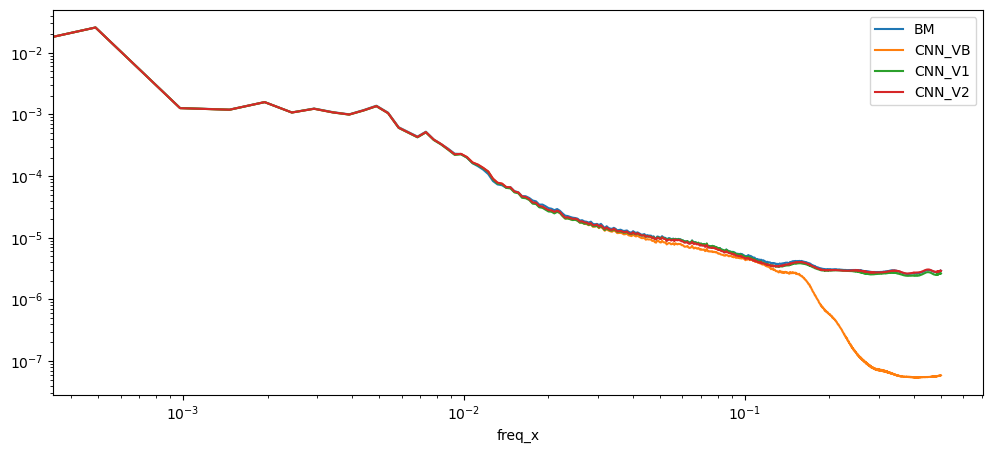

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))

# (ps_ssh * ps_ssh.freq_x).mean(['z', 'y']).plot(label='SSH', ax=ax)
(ps_bm * ps_bm.freq_x).mean(['z', 'y']).plot(label='BM', ax=ax)
(ps_bmvb * ps_bmvb.freq_x).mean(['z', 'y']).plot(label='CNN_VB', ax=ax)
(ps_bmv1 * ps_bmv1.freq_x).mean(['z', 'y']).plot(label='CNN_V1', ax=ax)
(ps_bmv2 * ps_bmv2.freq_x).mean(['z', 'y']).plot(label='CNN_V2', ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
plt.show()

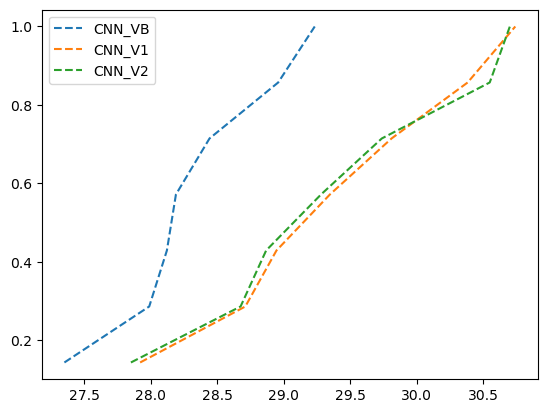

In [43]:
ECDF(CNN_VB=psnr(targets_it, inputs - TBMVB, R=RIT), CNN_V1=psnr(targets_it, inputs - TBMV1, R=RIT), CNN_V2=psnr(targets_it, inputs - TBMV2, R=RIT))

In [44]:
print('TBMVB: '), metrics_report(targets_it, inputs - TBMVB)
print('TBMV1: '), metrics_report(targets_it, inputs - TBMV1)
print('TBMV2: '), metrics_report(targets_it, inputs - TBMV2)

TBMVB: 
R2: -151.8554, PBias: -137.6680, RMSE: 0.0000
TBMV1: 
R2: -74.0533, PBias: -109.5763, RMSE: 0.0000
TBMV2: 
R2: -24.2832, PBias: -135.9625, RMSE: 0.0000


(None, None)

In [26]:
da_it = xr.DataArray(targets_it, dims=['z', 'x', 'y'])

da_itvb = xr.DataArray(inputs - TBMVB, dims=['z', 'x', 'y'])
da_itv1 = xr.DataArray(inputs - TBMV1, dims=['z', 'x', 'y'])
da_itv2 = xr.DataArray(inputs - TBMV2, dims=['z', 'x', 'y'])

ps_it = xrft.power_spectrum(da_it, 'x', window='hamming')

ps_itvb = xrft.power_spectrum(da_itvb, 'x', window='hamming')
ps_itv1 = xrft.power_spectrum(da_itv1, 'x', window='hamming')
ps_itv2 = xrft.power_spectrum(da_itv2, 'x', window='hamming')

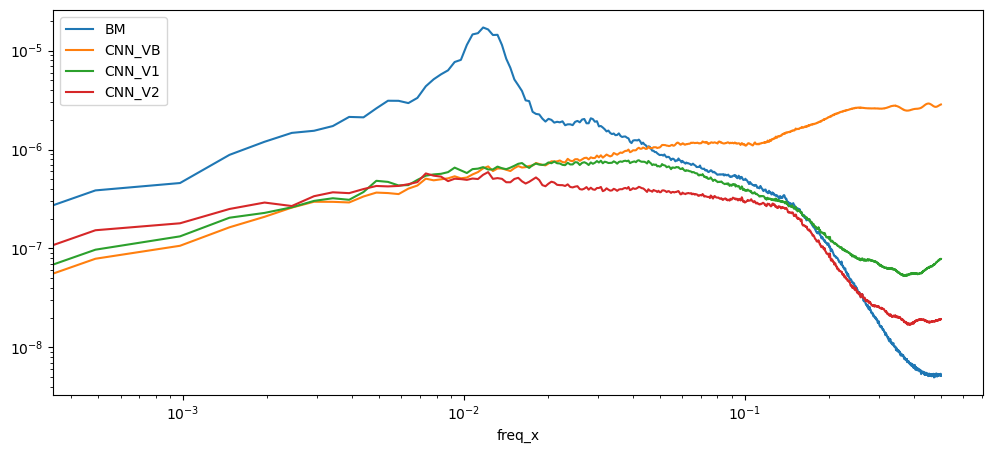

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))

(ps_it * ps_it.freq_x).mean(['z', 'y']).plot(label='IT', ax=ax)
(ps_itvb * ps_itvb.freq_x).mean(['z', 'y']).plot(label='CNN_VB', ax=ax)
(ps_itv1 * ps_itv1.freq_x).mean(['z', 'y']).plot(label='CNN_V1', ax=ax)
(ps_itv2 * ps_itv2.freq_x).mean(['z', 'y']).plot(label='CNN_V2', ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
plt.show()

In [13]:
ITVB = inference(CGANB, ssh, CNN=False)
ITV1 = inference(CGANV1, ssh, CNN=False)
ITV2 = inference(CGANV2, ssh, CNN=False)
ITV3 = inference(CGANV3, ssh, CNN=False)
ITVF = inference(CGANFN, ssh, CNN=False)

100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


In [14]:
TITVB = transformation(ITVB, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=True)
TITV1 = transformation(ITV1, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=True)
TITV2 = transformation(ITV2, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=True)
TITV3 = transformation(ITV3, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=True)
TITVF = transformation(ITVF, MinMax_transform_dict['targets_it'], transform_method='MinMax', inverse_transform=True)

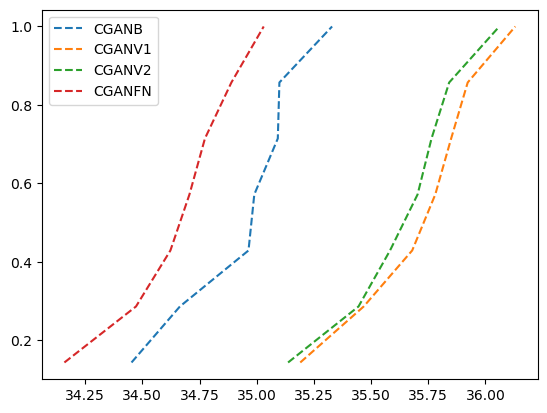

In [93]:
ECDF(CGANB=psnr(targets_it, reshape_back_arr(TITVB), R=RIT), CGANV1=psnr(targets_it, reshape_back_arr(TITV1), R=RIT), 
     CGANV2=psnr(targets_it, reshape_back_arr(TITV2), R=RIT), 
     CGANFN=psnr(targets_it, reshape_back_arr(TITVF), R=RIT))

In [27]:
da_it = xr.DataArray(targets_it, dims=['z', 'x', 'y'])
da_itvb = xr.DataArray(reshape_back_arr(TITVB), dims=['z', 'x', 'y'])
da_itv1 = xr.DataArray(reshape_back_arr(TITV1), dims=['z', 'x', 'y'])
da_itv2 = xr.DataArray(reshape_back_arr(TITV2), dims=['z', 'x', 'y'])
da_itv3 = xr.DataArray(reshape_back_arr(TITV3), dims=['z', 'x', 'y'])
da_itvf = xr.DataArray(reshape_back_arr(TITVF), dims=['z', 'x', 'y'])                       


ps_it = xrft.power_spectrum(da_it, 'x', window='hamming')
ps_itvb = xrft.power_spectrum(da_itvb, 'x', window='hamming')
ps_itv1 = xrft.power_spectrum(da_itv1, 'x', window='hamming')
ps_itv2 = xrft.power_spectrum(da_itv2, 'x', window='hamming')
ps_itv3 = xrft.power_spectrum(da_itv3, 'x', window='hamming')
ps_itvf = xrft.power_spectrum(da_itvf, 'x', window='hamming')

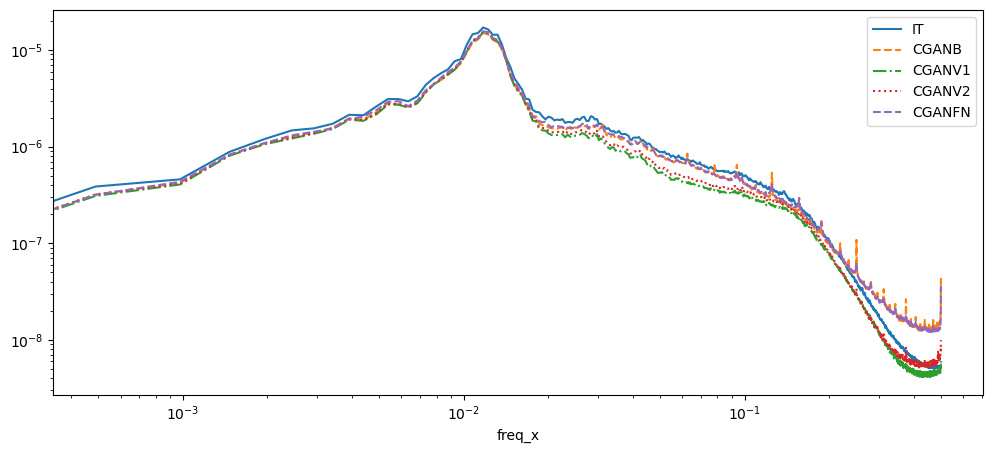

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))

(ps_it * ps_it.freq_x).mean(['z', 'y']).plot(label='IT', ax=ax)
(ps_itvb * ps_itvb.freq_x).mean(['z', 'y']).plot(label='CGANB',  linestyle='--', ax=ax)
(ps_itv1 * ps_itv1.freq_x).mean(['z', 'y']).plot(label='CGANV1', linestyle='-.', ax=ax)
(ps_itv2 * ps_itv2.freq_x).mean(['z', 'y']).plot(label='CGANV2', linestyle=':', ax=ax)
# (ps_itv3 * ps_itv3.freq_x).mean(['z', 'y']).plot(label='CGANV3', ax=ax)
(ps_itvf * ps_itvf.freq_x).mean(['z', 'y']).plot(label='CGANFN', linestyle='--', ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
plt.show()

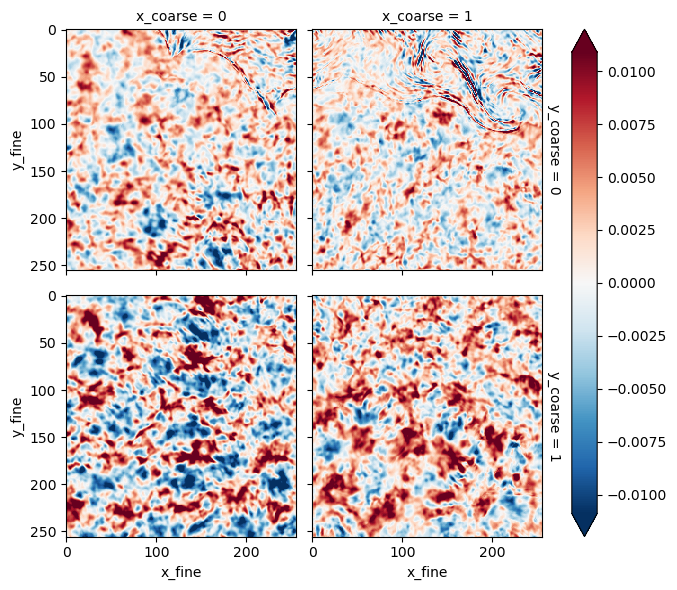

In [141]:
gen = reshape_back_arr(TITVB)[0].reshape(8, 256, 8, 256)
xr.DataArray(gen, dims=['x_coarse', 'x_fine', 'y_coarse', 'y_fine']).isel(x_coarse=slice(1, 3), y_coarse=slice(0, 2)).plot(x='x_fine', y='y_fine', col='x_coarse', row='y_coarse', robust=True, yincrease=False)
plt.show()

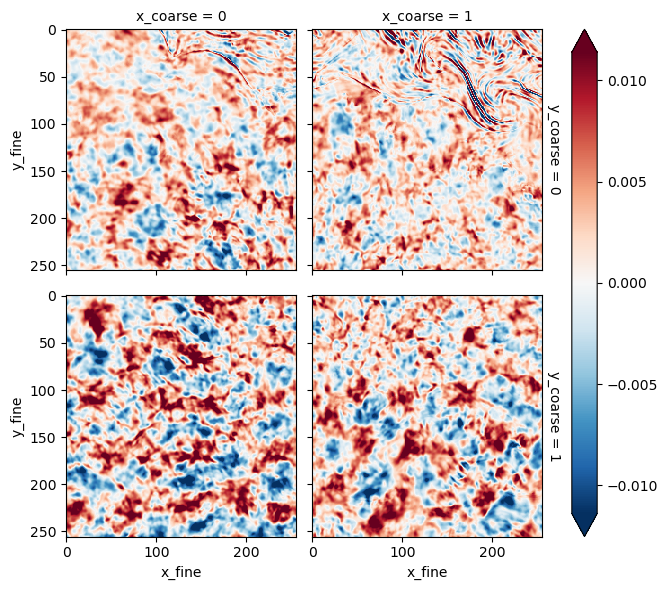

In [142]:
tar = targets_it[0].reshape(8, 256, 8, 256)
xr.DataArray(tar, dims=['x_coarse', 'x_fine', 'y_coarse', 'y_fine']).isel(x_coarse=slice(1, 3), y_coarse=slice(0, 2)).plot(x='x_fine', y='y_fine', col='x_coarse', row='y_coarse', robust=True, yincrease=False)
plt.show()

In [16]:
reshape_back_arr(TITVB).shape

(7, 2048, 2048)

In [17]:
# Find location to put data
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
print(PERSISTENT_BUCKET)

gs://leap-persistent/smhassanerfani


In [58]:
ds.to_zarr(PERSISTENT_BUCKET + '/LLC4320/08112023.zarr', mode='w')

In [55]:
ds = xr.Dataset({
    'GT': (["time", "lon", "lat"], targets_it),
    'M1': (["time", "lon", "lat"], reshape_back_arr(TITVB)),
    'M2': (["time", "lon", "lat"], reshape_back_arr(TITV1)),
    'M3': (["time", "lon", "lat"], reshape_back_arr(TITV2)),
    'M4': (["time", "lon", "lat"], reshape_back_arr(TITVF))
              },
     coords=dict(
        time=arr[49:56],
        lon=xr.open_zarr(filtered_link)['ssh_filtered'][arr[49:56], 56:-56, 56:-56].x0.values,
        lat=xr.open_zarr(filtered_link)['ssh_filtered'][arr[49:56], 56:-56, 56:-56].y0.values
    )
)
ds

<xarray.Dataset>
Dimensions:  (time: 7, lon: 2048, lat: 2048)
Coordinates:
  * time     (time) int64 10 36 40 46 24 53 65
  * lon      (lon) float64 -14.32 -14.3 -14.28 -14.26 ... 28.26 28.28 28.3 28.32
  * lat      (lat) float64 -56.38 -56.37 -56.36 -56.35 ... -27.65 -27.63 -27.61
Data variables:
    GT       (time, lon, lat) float32 0.0008206 0.001747 0.003112 ... 0.0 0.0
    M1       (time, lon, lat) float64 0.003356 0.003404 ... 0.006101 0.006281
    M2       (time, lon, lat) float64 0.002641 0.002373 ... 0.00653 0.006862
    M3       (time, lon, lat) float64 0.003203 0.002741 ... 0.006369 0.007011
    M4       (time, lon, lat) float64 0.0003226 0.0004598 ... 0.005507 0.005523

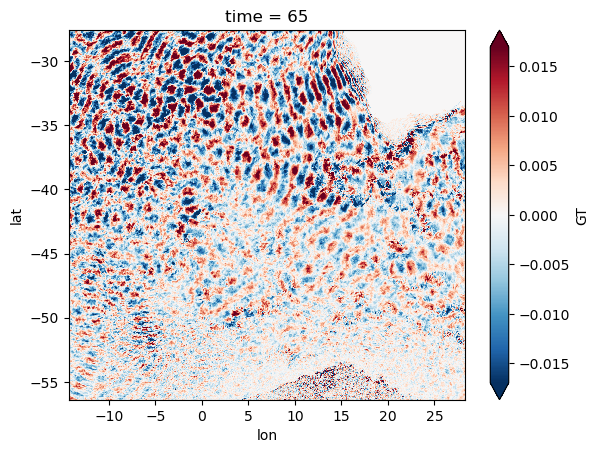

In [56]:
ds['GT'].isel(time=-1).plot(x='lon', y='lat',robust=True)

In [59]:
import fsspec
gcs = fsspec.filesystem('gcs')
gcs.ls(PERSISTENT_BUCKET+'/LLC4320')

['leap-persistent/smhassanerfani/LLC4320/08112023.zarr']

In [60]:
ds1 = xr.open_zarr(PERSISTENT_BUCKET + '/LLC4320/08112023.zarr')

In [61]:
ds1

<xarray.Dataset>
Dimensions:  (time: 7, lon: 2048, lat: 2048)
Coordinates:
  * lat      (lat) float64 -56.38 -56.37 -56.36 -56.35 ... -27.65 -27.63 -27.61
  * lon      (lon) float64 -14.32 -14.3 -14.28 -14.26 ... 28.26 28.28 28.3 28.32
  * time     (time) int64 10 36 40 46 24 53 65
Data variables:
    GT       (time, lon, lat) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    M1       (time, lon, lat) float64 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    M2       (time, lon, lat) float64 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    M3       (time, lon, lat) float64 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    M4       (time, lon, lat) float64 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>